# Check GC feasibility by cMCS 

According to [[1]](https://www.nature.com/articles/ncomms15956), only if a cMCS enabling product yields below a given threshold while ensuring production and growth yields above their respective thresholds, strong coupling is possible. With this reasoning, a weak coupling will be possible if a cMCS is found that enable a minimum yield of product from the selected carbon source.

In [2]:
#IMPORTS
import re
import cobra
import numpy as np
import pandas as pd
import straindesign as sd
import plotly.express as px
import plotly.graph_objects as go

In [35]:
model_path = 'synecococcus_LA_ko_results/cyanobacteria_models/paper/iMS837/syneco_acetate_mixotrophic_conditions.json'

## 1. Load a reduced model to reduce computation time

In [36]:
model = cobra.io.load_json_model(model_path)
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ac_e,EX_ac_e,0.1802,2,17.59%
co2_e,EX_co2_e,0.9083,1,44.34%
cobalt2_e,EX_cobalt2_e,0.002271,0,0.00%
fe3_e,EX_fe3_e,0.009585,0,0.00%
h_e,EX_h_e,0.4743,0,0.00%
hco3_e,EX_hco3_e,0.7798,1,38.07%
k_e,EX_k_e,0.003423,0,0.00%
mg2_e,EX_mg2_e,0.005934,0,0.00%
na1_e,EX_na1_e,0.005821,0,0.00%
nh4_e,EX_nh4_e,0.5291,0,0.00%


In [37]:
len(model.reactions)

752

In [38]:
model.id = 'iMS837_acetate_mixotrophy'

## 2. Define thresholds previously computed in model pre-proccessing

In [39]:
growth_fraction = 0.1
minimum_yield_from_biomass = 2
minimum_yield_from_substrate = 0.05

## 3. Define the model targets

In [40]:
target_biomass = 'BOF_acetate_mixotrophy'
target_reaction = 'EX_ALA_e'
carbon_source = 'EX_ac_e'

## 4. Define the constraints

In [13]:
#define a constraint generator:
from cameo.flux_analysis.simulation import lmoma, pfba

#this is a initial approach for the generator
def gc_filtering_constraints_generator(model, target_biomass, target_reaction, carbon_source, growth_fraction,
                                       yield_from_biomass=2, yield_from_sustrate=0.05):
    
    pfba_result = pfba(model)
    wt_biomass = pfba_result.fluxes[target_biomass]
    bp_constraint_pattern = '%s >= %s'
    gc_constraint_pattern = '%s <= %s'
    minimum_growth_constraint = bp_constraint_pattern % (target_biomass, growth_fraction*wt_biomass)
    minimum_yield_constraint = bp_constraint_pattern % (target_reaction, 0.001)
    bioprocess_constraints = [minimum_growth_constraint, minimum_yield_constraint]
    
    #SGC requires a yield of the product from the biomass so we are going to impose this yield as a constraint
    if min(model.reactions.get_by_id(target_reaction).bounds) >= 0:
        sign = ' - '
        
    else:
        sign = ' + '
    
    strong_coupling_constraint = gc_constraint_pattern % (sign.join([target_reaction,
                                                                     str(yield_from_biomass)+' '+target_biomass]), 0)
        
    #WGC requires at least a positive yield of the product from the sustrate, that will be imposed as the constraint
    if min(model.reactions.get_by_id(target_reaction).bounds) >= 0 and min(model.reactions.get_by_id(carbon_source).bounds) >= 0:
        sign = ' - '
    
    else:
        sign = ' + '
            
    weak_coupling_constraint = gc_constraint_pattern % (sign.join([target_reaction,
                                                                   str(yield_from_sustrate)+' '+carbon_source]) , 0)

    gc_constraints =  [strong_coupling_constraint, weak_coupling_constraint]
    
    constraints = {'bioprocess_constraints' : bioprocess_constraints,
                   'coupling_constraints' : gc_constraints}
    
    return constraints



In [41]:
print(constraints)

{'bioprocess_constraints': ['BOF_acetate_mixotrophy >= 0.006155664569032385', 'EX_ALA_e >= 0.001'], 'coupling_constraints': ['EX_ALA_e - 2 BOF_acetate_mixotrophy <= 0', 'EX_ALA_e + 0.05 EX_ac_e <= 0']}


## 5. Check the resulting metabolic spaces for each constraint

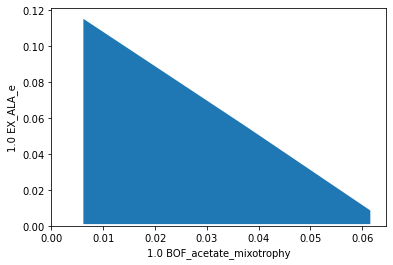

([[0.006155665, 0.001],
  [0.007576202948717949, 0.001],
  [0.008996740897435898, 0.001],
  [0.010417278846153847, 0.001],
  [0.011837816794871794, 0.001],
  [0.013258354743589745, 0.001],
  [0.014678892692307693, 0.001],
  [0.01609943064102564, 0.001],
  [0.01751996858974359, 0.001],
  [0.01894050653846154, 0.001],
  [0.02036104448717949, 0.001],
  [0.021781582435897437, 0.001],
  [0.023202120384615384, 0.001],
  [0.024622658333333335, 0.001],
  [0.026043196282051283, 0.001],
  [0.027463734230769234, 0.001],
  [0.02888427217948718, 0.001],
  [0.03030481012820513, 0.001],
  [0.03172534807692308, 0.001],
  [0.03314588602564102, 0.001],
  [0.034566423974358974, 0.001],
  [0.035986961923076925, 0.001],
  [0.03740749987179487, 0.001],
  [0.03882803782051282, 0.001],
  [0.040248575769230764, 0.001],
  [0.041669113717948715, 0.001],
  [0.043089651666666666, 0.001],
  [0.04451018961538462, 0.001],
  [0.04593072756410256, 0.001],
  [0.04735126551282051, 0.001],
  [0.04877180346153846, 0.001],


In [42]:
sd.plot_flux_space( model,
                   (target_biomass,(target_reaction)),
                   constraints=constraints['bioprocess_constraints'])

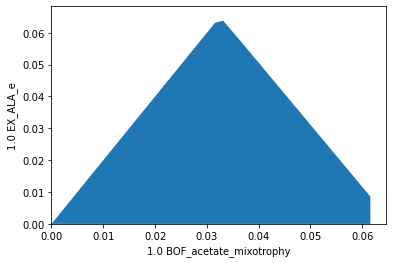

([[0.0, 0.0],
  [0.0015783755128205128, 0.0],
  [0.0031567510256410255, 0.0],
  [0.0047351265384615385, 0.0],
  [0.006313502051282051, 0.0],
  [0.007891877564102564, 0.0],
  [0.009470253076923077, 0.0],
  [0.011048628589743589, 0.0],
  [0.012627004102564102, 0.0],
  [0.014205379615384615, 0.0],
  [0.015783755128205127, 0.0],
  [0.01736213064102564, 0.0],
  [0.018940506153846154, 0.0],
  [0.020518881666666666, 0.0],
  [0.022097257179487177, 0.0],
  [0.023675632692307692, 0.0],
  [0.025254008205128204, 0.0],
  [0.026832383717948716, 0.0],
  [0.02841075923076923, 0.0],
  [0.029989134743589742, 0.0],
  [0.031567510256410254, 0.0],
  [0.03314588576923077, 0.0],
  [0.03472426128205128, 0.0],
  [0.03630263679487179, 0.0],
  [0.03788101230769231, 0.0],
  [0.039459387820512816, 0.0],
  [0.04103776333333333, 0.0],
  [0.042616138846153846, 0.0],
  [0.044194514358974354, 0.0],
  [0.04577288987179487, 0.0],
  [0.047351265384615385, 0.0],
  [0.04892964089743589, 0.0],
  [0.05050801641025641, 0.0],
 

In [43]:
sd.plot_flux_space( model,
                   (target_biomass,(target_reaction)),
                   constraints=constraints['coupling_constraints'][0])

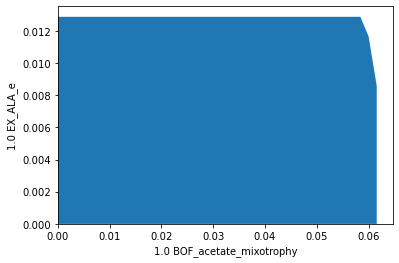

([[0.0, 0.0],
  [0.0015783755128205128, 0.0],
  [0.0031567510256410255, 0.0],
  [0.0047351265384615385, 0.0],
  [0.006313502051282051, 0.0],
  [0.007891877564102564, 0.0],
  [0.009470253076923077, 0.0],
  [0.011048628589743589, 0.0],
  [0.012627004102564102, 0.0],
  [0.014205379615384615, 0.0],
  [0.015783755128205127, 0.0],
  [0.01736213064102564, 0.0],
  [0.018940506153846154, 0.0],
  [0.020518881666666666, 0.0],
  [0.022097257179487177, 0.0],
  [0.023675632692307692, 0.0],
  [0.025254008205128204, 0.0],
  [0.026832383717948716, 0.0],
  [0.02841075923076923, 0.0],
  [0.029989134743589742, 0.0],
  [0.031567510256410254, 0.0],
  [0.03314588576923077, 0.0],
  [0.03472426128205128, 0.0],
  [0.03630263679487179, 0.0],
  [0.03788101230769231, 0.0],
  [0.039459387820512816, 0.0],
  [0.04103776333333333, 0.0],
  [0.042616138846153846, 0.0],
  [0.044194514358974354, 0.0],
  [0.04577288987179487, 0.0],
  [0.047351265384615385, 0.0],
  [0.04892964089743589, 0.0],
  [0.05050801641025641, 0.0],
 

In [44]:
sd.plot_flux_space( model,
                   (target_biomass,(target_reaction)),
                   constraints=constraints['coupling_constraints'][1])

## 5. Search cMCS for SGC OR WGC

In [46]:
#IMPLEMENT A GC FEASIBILITY FUNCTION
import time

def check_gc_feasibility(model, constraints):
    #Module protect contains constraints defining a metabolic space that must remain for the cMCS
    #In our case this region is the one enabling growth and synthesis above the threshold
    analysis_data = {'SGC' : [],
                     'WGC' : [],
                     'Time': []}
    
    module_protect  = sd.SDModule(model,
                                  sd.names.PROTECT, 
                                  constraints=constraints['bioprocess_constraints'])

    start = time.time()

    for c in constraints['coupling_constraints']:
        #Module supress contains constraints defining a metabolic space that should be excluded in the cMCS
        #Those are specific for the production envelope of the specific bioproduction and the type of GC
        module_supress = sd.SDModule(model,
                                     sd.names.SUPPRESS, 
                                     constraints=[c])

        modules = [module_protect, module_supress]
        
        if target_biomass in c :
            coupling_type = 'SGC'
        
        else:
            coupling_type = 'WGC'
        
        try:

            sols = sd.compute_strain_designs(model,
                                             sd_modules = modules,
                                             compress = False, #model is already compressed
                                             max_solutions=1,  #we only need to find 1
                                             solution_approach='any',
                                             time_limit=60)

            #‘any’ is usually the fastest option, since optimality is not enforced. Hereby computed MCS are still 
            #irreducible intervention sets, however, not MCS with the fewest possible number of interventions

            if len(sols.reaction_sd) > 0:
                print('A cMCS exists so a GC design with specified setup could potentially be found!')
                analysis_data[coupling_type].append(True)
                if coupling_type == 'SGC' :
                    print('A strong GC design is likely to be found')

                print('cMCS are :')
                for s in sols.reaction_sd:
                    print(s)
            else:
                print('No cMCS was found so GC design with this setup is not possible')
                analysis_data[coupling_type].append(False)
        
        except:
            print('Python module gives error with constraint "%s"!' % c)
            analysis_data[coupling_type].append('ERROR')

    end = time.time()
    analysis_data['Time'].append(end-start)
    
    print('All process duration was %s seconds' % (end-start))
    
    return pd.DataFrame(analysis_data, index = [model.id])

In [47]:
gc_feasibility_result = check_gc_feasibility(model, constraints)

No cMCS was found so GC design with this setup is not possible


No cMCS was found so GC design with this setup is not possible
All process duration was 218.9027783870697 seconds


In [48]:
gc_feasibility_result

,SGC,WGC,Time
iMS837_acetate_mixotrophy,False,False,218.902778


**For GC to be feasible, a cMCS must be found in at least one of the 2 constrains**. It can happen that cMCS are found for both constrains.

In [50]:
gc_feasible = any(gc_feasibility_result.loc[model.id][:-1])
if gc_feasible:
    #NOW THE WORKFLOW SHOULD START

False

**Results of filter with already obtained designs**

| SD Case | Max Coupling Strenght | SGC prediction | WGC prediction | Correct | Rxns | Time(min) |
| --- | --- | --- | --- | --- | --- | --- |
| ecoli_isobutanol_ko_results | 0.97  | NO | YES | Both | 1822 | 23.5 |
| synecococcus_LA_ko_results (autotrophy) | 0 | NO | NO | Both | 752 | 2.97 |
| synecococcus_LA_ko_results (acetate photomixotrophy) | 0 | NO | NO | Both | 752 | 3.67 |
| synecococcus_LA_ko_results (glucose photomixotrophy)| 0 | --- | --- | --- | 752 | ERROR |
| putida_pet_to_pha_ko_results | 1 | YES | YES | Both | 1385 | 14.5 |

This preliminary results are good enough to apply the filter in the workflow, as they predict if there are couplings and the type within an acceptable time.